In [1]:
import json

import folium
from IPython.display import display, HTML

import pandas as pd
import seaborn as sns

from os.path import abspath
from darts import TimeSeries

# WWTP inflow dataset: Horsens

In [2]:
# Define the coordinates for Horsens Municipality
horsens_coords = [55.8607, 9.8502]  # Approximate center of Horsens Municipality
dmi_station_coords = [55.868, 9.7872]
wwtp_coords = [55.85512, 9.85414]

m = folium.Map(location=horsens_coords, zoom_start=12)

folium.Marker(
    dmi_station_coords,
    popup="weather station",
    tooltip="DMI station",
    icon=folium.Icon(icon="cloud", color="green"),
).add_to(m)
folium.Marker([55.8540, 9.8600], popup="WWTP", tooltip="WWTP").add_to(m)

display(
    HTML(
        """
    <div style="width: 50%; height: 50%; margin: auto;">
        """
        + m._repr_html_()
        + """
    </div>
"""
    )
)

## Loading data

In [3]:
path_to_inflow = "../observations/wwtp.csv"
path_to_dmi_data = "../observations/dmi.csv"

# Inflow measuring unit is m3/h
inflow = pd.read_csv(abspath(path_to_inflow), parse_dates=True, index_col=0, sep=";")
inflow.index.name = "time"
inflow.index = inflow.index.tz_localize(
    "Europe/Copenhagen", ambiguous="NaT"
).tz_convert("utc")

DMI always provides data in UTC (https://opendatadocs.dmi.govcloud.dk/en/Data/Climate_Data)

In [4]:
climate = pd.read_csv(abspath(path_to_dmi_data), parse_dates=True, index_col=0, sep=",")

In [5]:
horsens = inflow.merge(climate, left_index=True, right_index=True, how="inner")
horsens.head()

,FB20F11_81,acc_precip,mean_pressure,mean_radiation,mean_relative_hum,mean_temp,temp_grass,temp_soil_10,temp_soil_30
time,,,,,,,,,
2023-09-21 10:00:00+00:00,974.452333,0.0,998.4,535.0,68.5,20.8,20.5,15.0,14.6
2023-11-01 05:00:00+00:00,1701.950500,0.0,1005.4,0.0,98.0,-3.4,-3.6,8.2,9.7
2023-11-07 08:00:00+00:00,1338.937500,0.0,1000.8,53.0,98.3,4.0,1.3,8.5,9.5
2023-11-07 09:00:00+00:00,2243.327667,0.0,1001.1,162.0,98.5,7.6,5.6,8.5,9.4
2023-11-07 10:00:00+00:00,1988.214167,0.0,1001.7,166.0,95.5,8.6,9.5,8.4,9.4


### Visualization

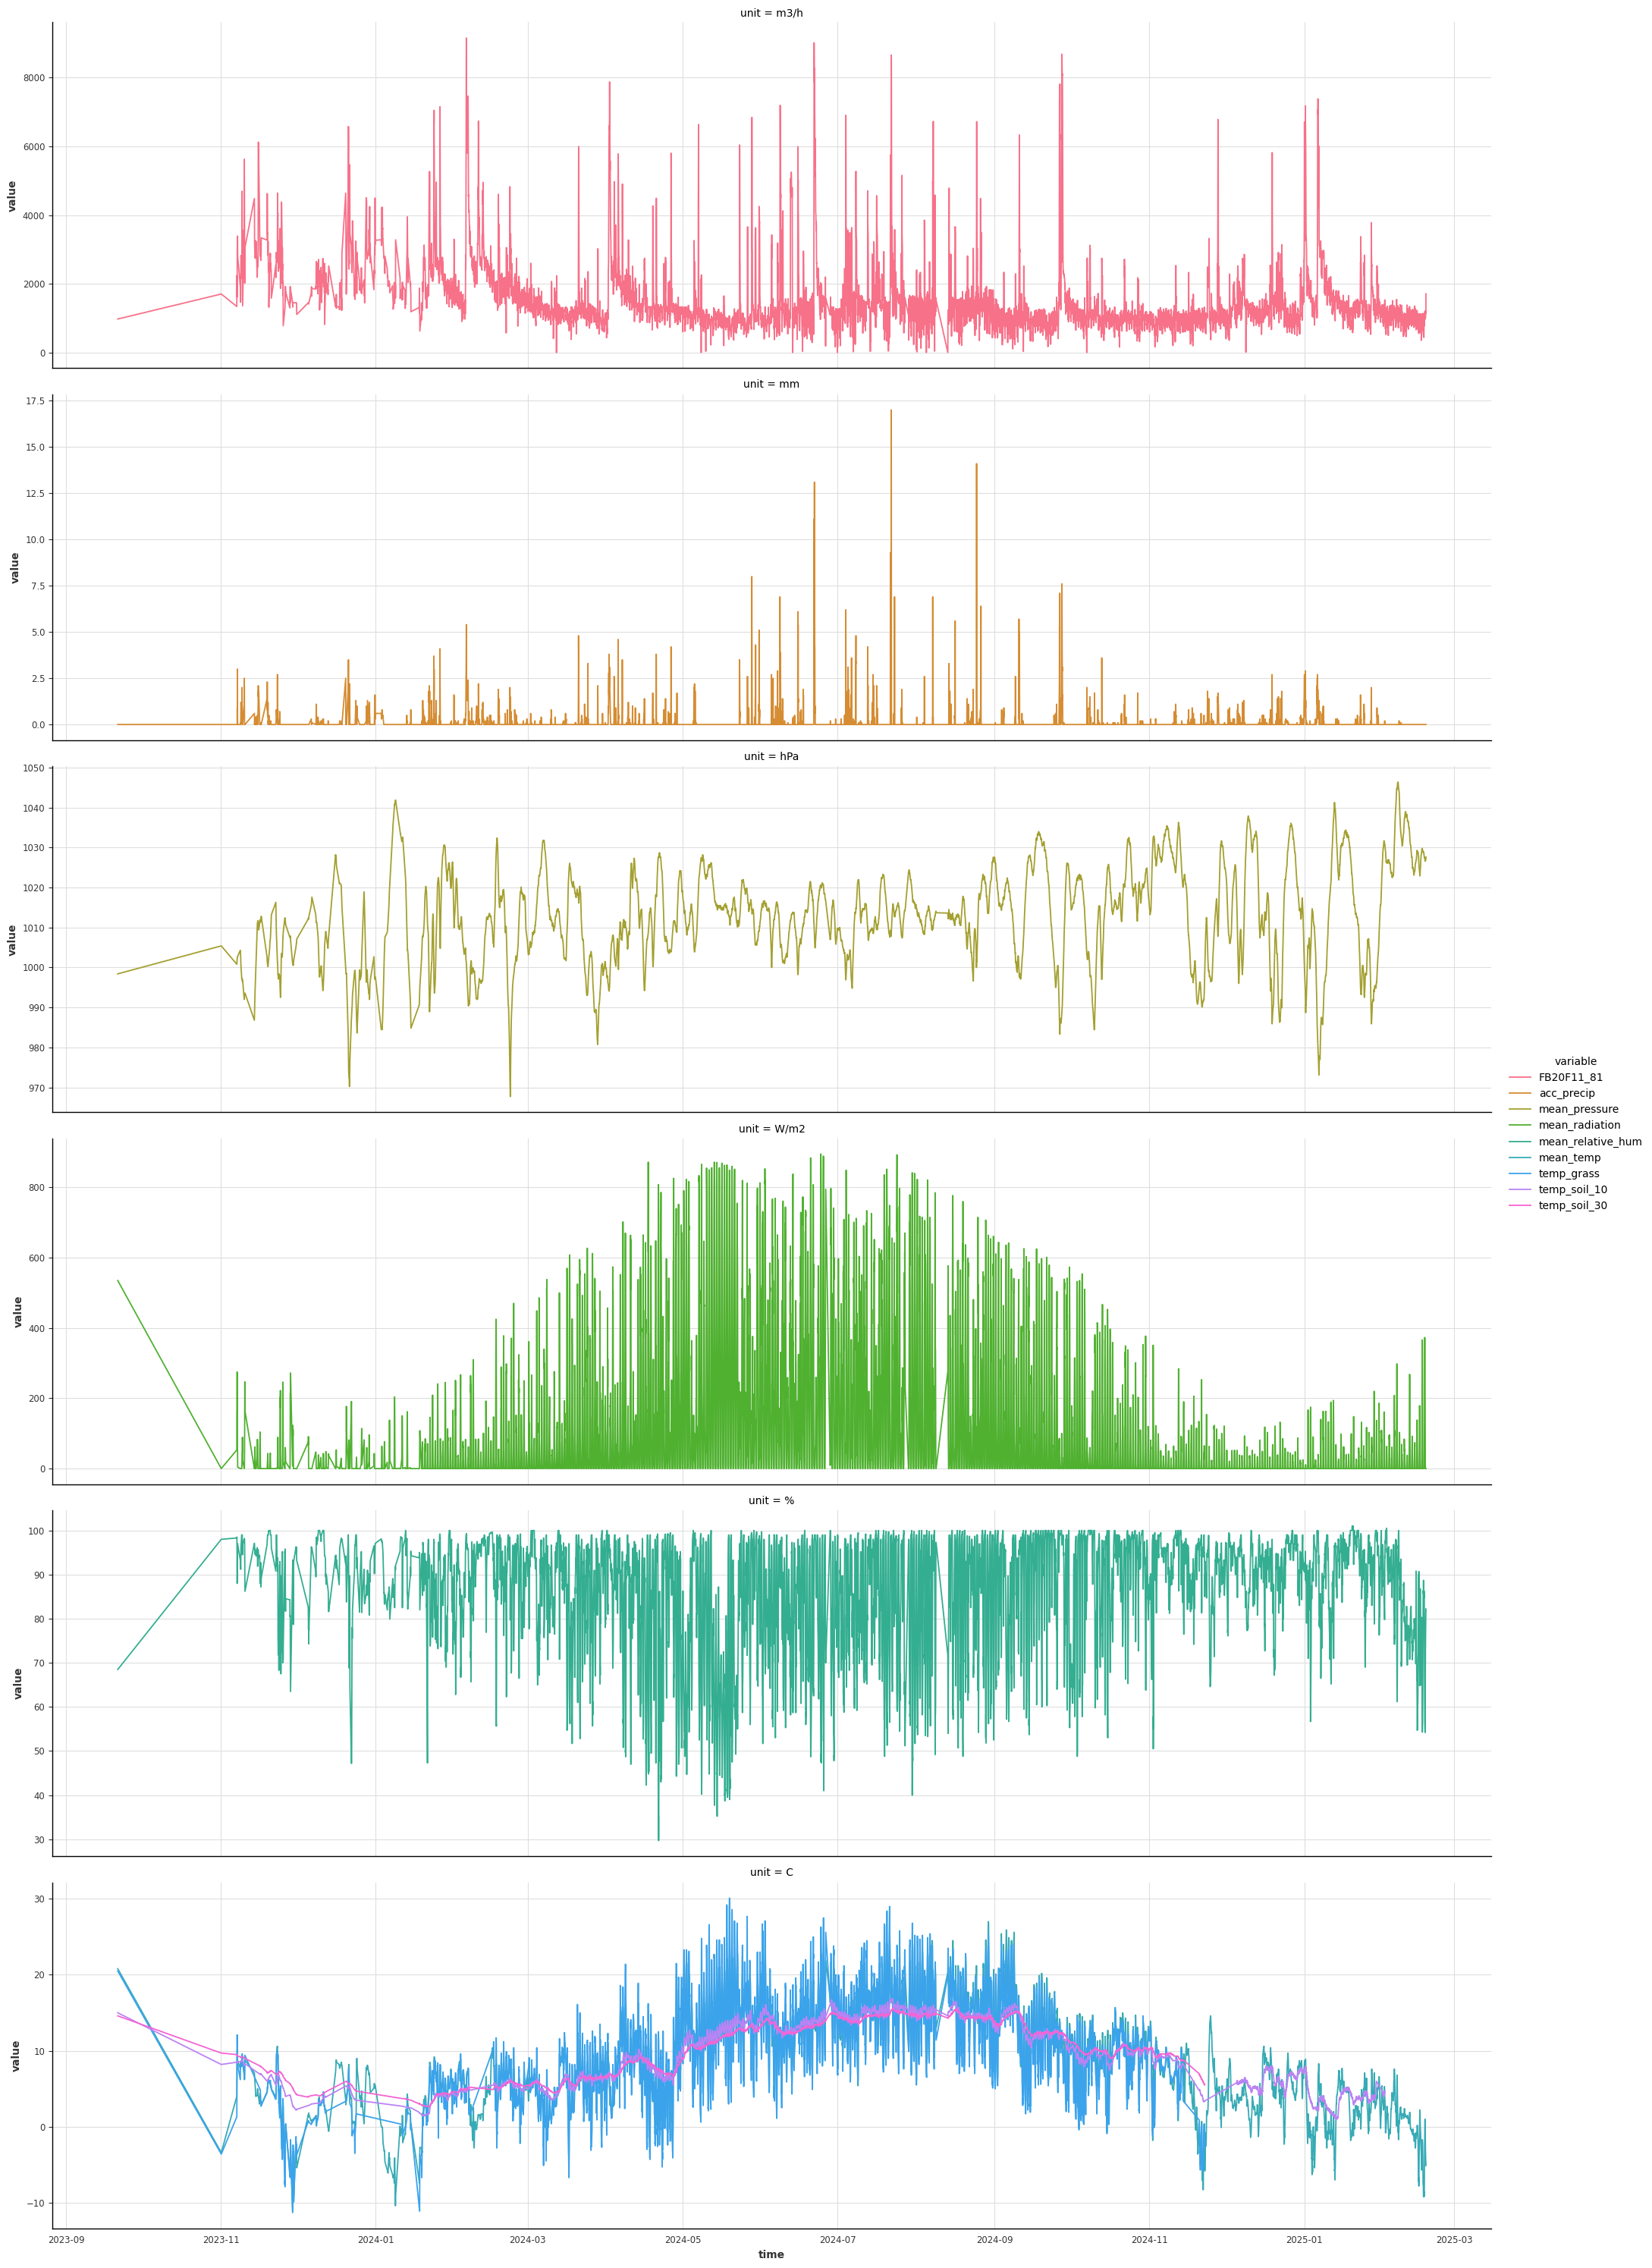

In [6]:
with open("./units.json", "r") as f:
    units = json.load(f)

dfmelt = horsens.melt(ignore_index=False)
dfmelt["unit"] = dfmelt["variable"].map(units)
sns.relplot(
    dfmelt.reset_index(),
    x="time",
    y="value",
    row="unit",
    kind="line",
    hue="variable",
    facet_kws=dict(sharey=False),
    aspect=4,
);

### Gaps

In [83]:
ts = TimeSeries.from_dataframe(horsens, freq="h")
ts.gaps()["gap_size"].describe()

The provided DatetimeIndex was associated with a timezone, which is currently not supported by xarray. To avoid unexpected behaviour, the tz information was removed. Consider calling `ts.time_index.tz_localize(UTC)` when exporting the results.To plot the series with the right time steps, consider setting the matplotlib.pyplot `rcParams['timezone']` parameter to automatically convert the time axis back to the original timezone.


count     63.000000
mean      39.761905
std      123.437814
min        1.000000
25%        7.000000
50%       14.000000
75%       31.500000
max      978.000000
Name: gap_size, dtype: float64